**Importing dependencies**

In [1]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

TensorFlow 2.x selected.


**Importing the data**

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print(metadata)

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-

**Output Labels**

In [0]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

**Preprocessing**

Normalizing the data to prevent slow gradient convergence. Caching it in memory to prevent loading it from disk while training.

In [0]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# cache the dataset for better loading
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

**Creating the model**

`tf.keras.Sequential` creates a neural net by taking layers from input to output sequetially. We flatten the image to send it as a single dimensional array of size 784 to the input layers.

`tf.keras.layers.Conv2D` and `tf.keras.layers.MaxPooling2D` - The first convolution layer maintains the image size using padding, enhances the details present in the image and outputs 32 different convolutions. These images are then passed through a max pooling layer to remove insignificant details and reduceing image size.

We're using `ReLU (Rectified Linear Unit)` as an activation function allows us to deal with the non linear dependencies / interaction between inputs values
as ReLU only outputs the value when the net result produced at the node is positive. 

We're using `Softmax` as the activation of output layers which is like logistic regression but for predicting probabilistic values for multi-label classification. It provides a probability of current input Xi belonging to the class label Lj.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

**Compiling the model**

Using `sparse_categorical_crossentropy` as the `loss` functon to measure the dissimilarity between the distribution of observed class labels and the predicted probabilities.
1. Sparse refers to using a single integer from zero to the number of classes minus one for class labels, instead of a dense one-hot encoding of the class label (e.g. { 1,0,0; 0,1,0; or 0,0,1 }).
2. Categorical refers to the possibility of having more than two classes.
3. Cross-entropy loss increases as the predicted probability diverges from the actual label.

Using TensorFlow's default `Adam` optimizer to adjust weights to reduce loss value, typical optimizer values range from 0.1 to 0.001 (lower the value more accurate the results and higher the training time)

Metrics are used to monitor the training and testing steps by specifying what parameter will be used to judge the performance of the model. The following example uses accuracy, the fraction of the images that are correctly classified.

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

**Training the model**

In [7]:
BATCH_SIZE = 32
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

model_history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 100s 53ms/step - loss: 0.4030 - accuracy: 0.8554
Epoch 2/10
1875/1875 [==============================] - 89s 47ms/step - loss: 0.2592 - accuracy: 0.9049
Epoch 3/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2159 - accuracy: 0.9205
Epoch 4/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1836 - accuracy: 0.9333
Epoch 5/10
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1560 - accuracy: 0.9428
Epoch 6/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1337 - accuracy: 0.9503
Epoch 7/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1129 - accuracy: 0.9585
Epoch 8/10
1875/1875 [==============================] - 91s 48ms/step - loss: 0.0962 - accuracy: 0.9638
Epoch 9/10
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0777 - accuracy: 0.9707
Epoch 10/10
1875/1875 [===================

**Evaluating accuracy against test data**

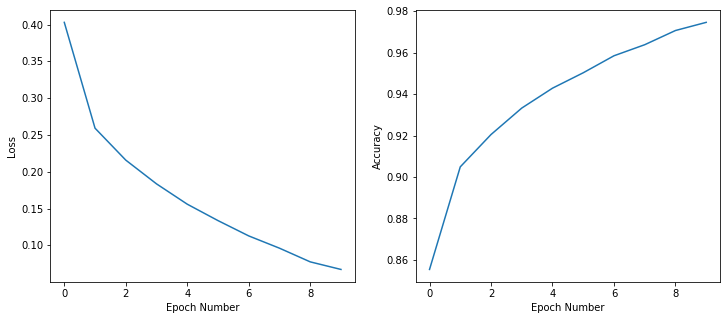

313/313 [==============================] - 8s 27ms/step - loss: 0.3353 - accuracy: 0.9168
Accuracy on test dataset: 0.9168


In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch Number')
plt.ylabel("Loss")
plt.plot(model_history.history['loss'])
plt.subplot(1,2,2)
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(model_history.history['accuracy'])
plt.show()

test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

**Predictions**

In [9]:
for test_images, test_labels in test_dataset.take(10):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)
  print("Predicted: ", labels[np.argmax(predictions[0])], ", Expected: ", labels[test_labels[0]])

Predicted:  Shirt , Expected:  Shirt
Predicted:  T-shirt/top , Expected:  T-shirt/top
Predicted:  Pullover , Expected:  Pullover
Predicted:  Dress , Expected:  Dress
Predicted:  Shirt , Expected:  T-shirt/top
Predicted:  Dress , Expected:  Dress
Predicted:  Sneaker , Expected:  Sneaker
Predicted:  Sandal , Expected:  Sandal
Predicted:  Ankle boot , Expected:  Ankle boot
Predicted:  Ankle boot , Expected:  Ankle boot
